### import libraries

In [49]:
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
sys.path.append(str('/home/alexandre/Documents/Projects'))

from slmOptim.patternSLM import patterns as pt
from slmOptim.optimization import phase_conjugation
from slmOptim.zeluxPy import helper_functions as cam
from slmOptim.optimization.init_experiment import InitExperiment
from slmOptim.optimization.iteration_algorithms import ContinuousSequential
from slmOptim.optimization.iteration_algorithms import StepwiseSequential

from slmOptim.optimization import cost_functions

### set experiment parameters

In [106]:
# SLM resolution
resX, resY = (800, 600)

# the number of controlled segments on the SLM
slm_segments = 30 ** 2

diam = int(slm_segments ** 0.5)

# size of macropixels on slm
n = round(math.log2(resY / diam + 1))
slm_macropixels = n + 1
print(slm_macropixels)
phase_steps = 8

# Define observation window on camera
roi_size = 600
off = (0, 0)

# Define camera macropixel, this is defined by the measured speckel grain
bins = 1

# Define camera acquisition parameters
exposure_time = 200
gain = 1
timeout= 100

# save data
path = '/home/optomeca/Documents/measurements'

5


### Initialize SLM and cam check a frame

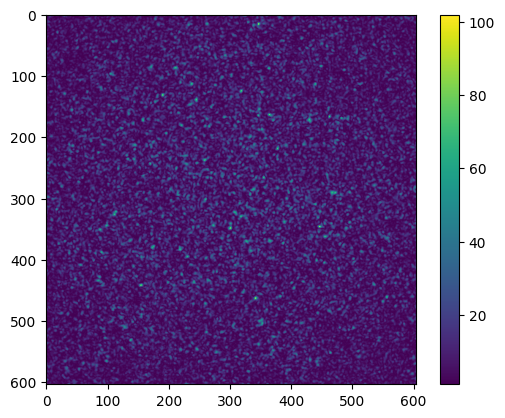

In [40]:
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
# slm = init.init_slm()
# 
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()

# print(frame.shape)

In [39]:
init.close_cam()

In [ ]:
init.close_cam()

### define cost function

In [64]:
# define target for the correlation cost function only
target_shape = (104, 104)
tgt = phase_conjugation.Target(target_shape)
target = tgt.square((4, 4), offset_x=0, offset_y=0, intensity=100)

# choose one cost function to pass to optim object    
# cost_fun = lambda x: cost_functions.corr_coef(x, target)
cost_fun = lambda x: cost_functions.snr(x, mask_radius=4)


##### Load patterns that will be used for optimization using a custom pattern loader

In [107]:
# create pattenr loader


pattern_loader = pt.OnePixelPatternGenerator(slm_segments)
len(pattern_loader)

697

#### run the algorithm

In [108]:
# cost = {}
# slm_segments = 256
# for step in range(1, 16):

# instantiate optimization class
optim = ContinuousSequential(slm, camera, 
                        pattern_loader, 
                        total_iterations=1,
                        slm_segments=slm_segments,
                        slm_macropixel=slm_macropixels,
                        phase_steps=phase_steps, 
                        save_path=path)

# pass cost function to object
optim.register_callback(cost_fun)

# run the algorithm
pattern, cost, frames = optim.run()
# optim.save_raw()        

  0%|          | 0/697 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

KeyboardInterrupt: 

### Apply optimized mask and get frame

Data transmitted


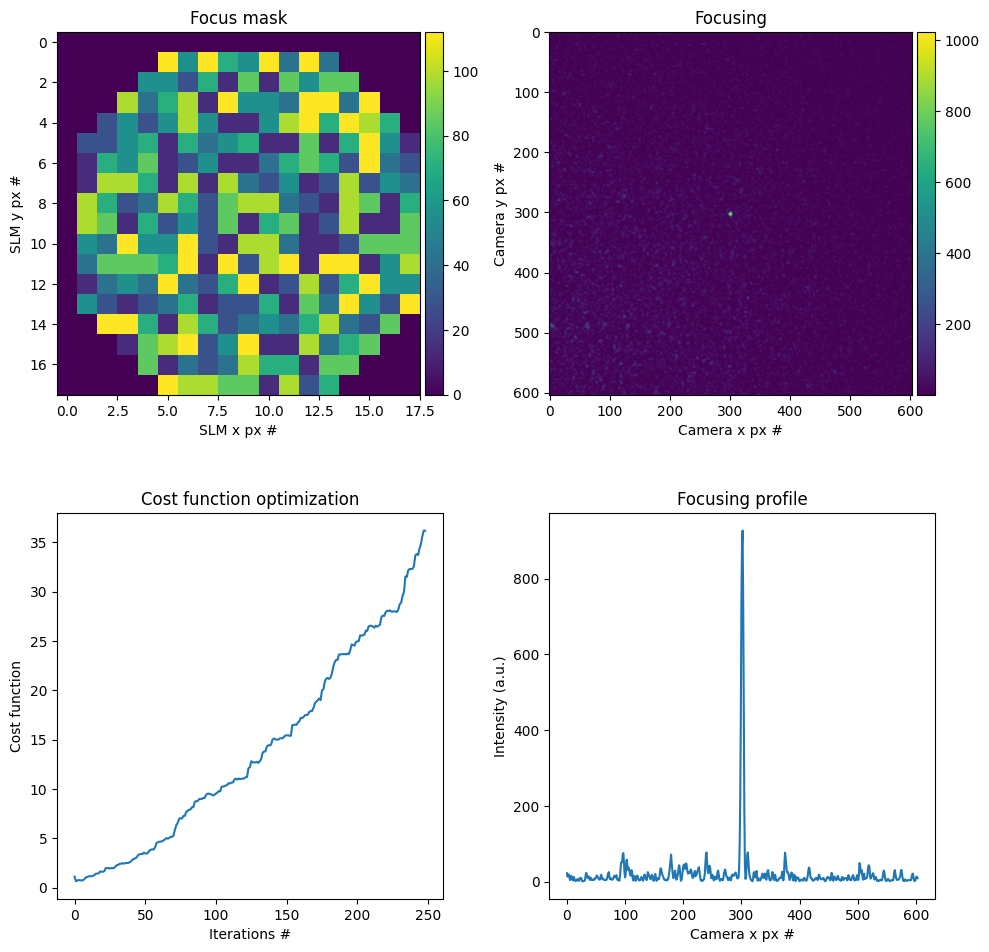

In [47]:
patternSLM = pt.Pattern(resX, resY)

mask = patternSLM._enlarge_pattern(pattern, slm_macropixels)
mask = patternSLM.add_subpattern(mask)

slm.sendArray(mask)
# # slm.updateArray(temp)

frame = camera.get_pending_frame_or_null()
focus = np.copy(frame.image_buffer)

optim.plot(focus, 301)
# optim.save_raw()

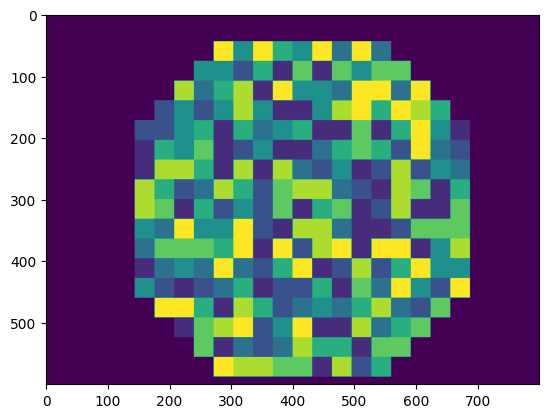

In [48]:
plt.imshow(mask)

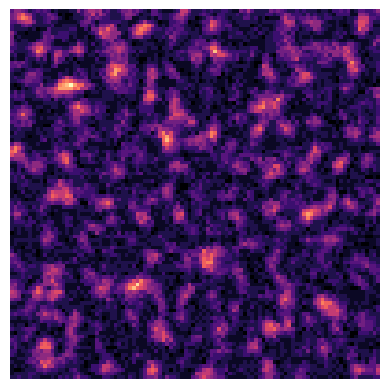

In [8]:
plt.imshow(focus[350:450, 350:450], cmap='magma')
plt.axis('off')
plt.savefig('optim.png', dpi=200, transparent=True, bbox_inches='tight')

In [ ]:
init.close_cam()
# init.close_slm()

In [33]:
pat = pt.Pattern(resX, resY)
mirror = pat.mirror()
slm.sendArray(mirror)

Data transmitted


1

In [ ]:
had = pt.HadamardPatternGenerator(256)
pattern = had[65]
patternSLM = pt.Pattern(resX, resY)

mask = patternSLM._enlarge_pattern(pattern, 5)
mask = patternSLM.add_subpattern(mask)

slm.sendArray(mask)
